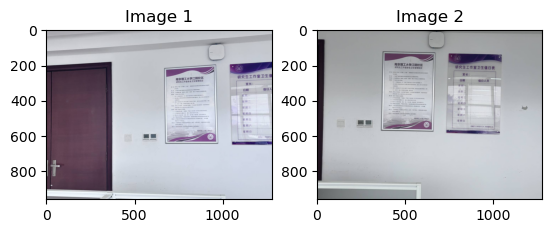

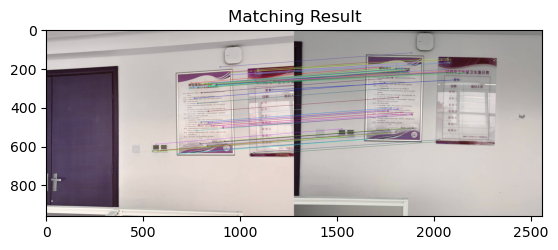

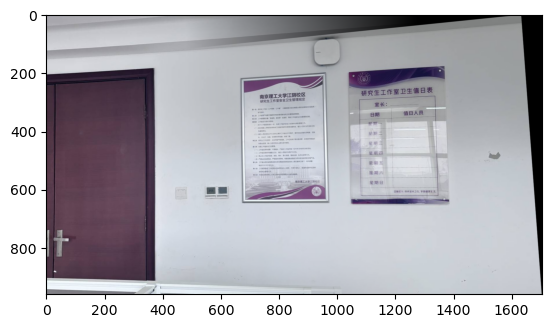

In [3]:
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt

class Image_Stitching():
    def __init__(self) :
        self.ratio=0.3
        self.min_match=10
        self.sift=cv2.SIFT_create()
        self.smoothing_window_size=800

    def registration(self,img1,img2):
        kp1, des1 = self.sift.detectAndCompute(img1, None)
        kp2, des2 = self.sift.detectAndCompute(img2, None)
        matcher = cv2.BFMatcher()
        raw_matches = matcher.knnMatch(des1, des2, k=2)
        good_points = []
        good_matches=[]
        for m1, m2 in raw_matches:
            if m1.distance < self.ratio * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])
        img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
        
        plt.imshow(img3)
        plt.title('Matching Result')
        plt.show()

        # cv2.imwrite('matching.jpg', img3)
        if len(good_points) > self.min_match:
            image1_kp = np.float32(
                [kp1[i].pt for (_, i) in good_points])
            image2_kp = np.float32(
                [kp2[i].pt for (i, _) in good_points])
            H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)
        return H

    def create_mask(self,img1,img2,version):
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2
        offset = int(self.smoothing_window_size / 2)
        barrier = img1.shape[1] - int(self.smoothing_window_size / 2)
        mask = np.zeros((height_panorama, width_panorama))
        if version== 'left_image':
            mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
            mask[:, barrier + offset:] = 1
        return cv2.merge([mask, mask, mask])

    def blending(self,img1,img2):
        H = self.registration(img1,img2)
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2

        panorama1 = np.zeros((height_panorama, width_panorama, 3))
        mask1 = self.create_mask(img1,img2,version='left_image')
        panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
        panorama1 *= mask1
        mask2 = self.create_mask(img1,img2,version='right_image')
        panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama))*mask2
        result=panorama1+panorama2

        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :]
        return final_result
def main(argv1,argv2):
    img1 = cv2.imread('data/1.jpg')
    img2 = cv2.imread('data/2.jpg')
    
        # 将 BGR 格式转换为 RGB 格式
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    # 显示第一张图像
    plt.subplot(1, 2, 1)
    plt.imshow(img1_rgb)
    plt.title('Image 1')
    
    # 显示第二张图像
    plt.subplot(1, 2, 2)
    plt.imshow(img2_rgb)
    plt.title('Image 2')
    
    plt.show()

    final=Image_Stitching().blending(img1,img2)
    final = cv2.convertScaleAbs(final)
    final = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)
    plt.imshow(final), plt.show()
    # cv2.imwrite('panorama.jpg', final)
if __name__ == '__main__':
    try: 
        main(sys.argv[1],sys.argv[2])
    except IndexError:
        print ("Please input two source images: ")
        print ("For example: python Image_Stitching.py '/Users/linrl3/Desktop/picture/p1.jpg' '/Users/linrl3/Desktop/picture/p2.jpg'")
    
